In [16]:

#########################
## Importing Libraries ##
#########################


# Numerical Libraries
import numpy as np
from jax import random, jit, vmap, grad, jacobian, hessian, lax
from jax import numpy as jnp
import optax
jnp_float = jnp.float32

# Tools from JAX
from jax.numpy.fft import fft, ifft
from jaxopt import BFGS

# Data Libraries
import pandas as pd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.cluster import HDBSCAN

# Plotting Libraries
import glob
from matplotlib import pyplot as plt
import seaborn as sns

# Timing/Progress Libraries
from time import time
from tqdm import tqdm

# System Libraries
from contextlib import contextmanager
import os
import sys

In [17]:
###############
## RNG SETUP ##
###############

# initialize random key
rng, _ = random.split(random.PRNGKey(12345))

In [18]:
###############################
## Signal Creation Functions ##
###############################

# decay function produces an exponential decay signal
@jit            # This is a decorator that compiles the function to make it faster
def decay(A, 𝜏, t):
    return A * jnp.exp(-t/𝜏)

# multi_decay function produces a sum of exponential decay signals 
@jit
def multi_decay(params, t):
    
    # first lets check that the number of parameters is even and at least 2
    assert len(params) >= 2, "Number of parameters must be at least 2"
    assert len(params) % 2 == 0, "Number of parameters must be even"
    
    A = jnp.array(params[::2])
    𝜏 = jnp.array(params[1::2])
    
    signal = jnp.zeros_like(t)
    for i in range(len(A)):
        signal += decay(A[i], 𝜏[i], t)
    
    return signal

def mean_bootstrap(key, signal):
    sample_indices = random.randint(
        key=key, 
        shape=(signal.shape[0],), 
        minval=0, 
        maxval=signal.shape[0]
    )
    signal_sample = signal[sample_indices]
    return jnp.mean(signal_sample)

In [ ]:
########################
## 1D Signal Creation ##
########################

# initialize random key for signal creation
# this guarantees that the signal is the same every time the code is run
rng, _ = random.split(random.PRNGKey(12345))

# Create the time array
n = 2726
dt = 480 # microseconds used to avoid floating point errors in t
t_max = n * dt
t = jnp.linspace(0, t_max, n, endpoint=False)/1000 # convert to milliseconds

# Create the signal
params = jnp.array([
    1.0, 100,
])
signal = multi_decay(params, t)

# Add noise to the signal
SNR = 100
noise_amplitude = jnp.sum(params[::2]) / SNR
rng, key = random.split(rng)
noisy_signal = signal + noise_amplitude * random.normal(key, signal.shape)

# Find the true mean of the noisy signal for use in true_params
d_true = jnp.mean(signal) + jnp.mean(noise_amplitude * random.normal(key, signal.shape))

# Alter signal with random offset
rng, key = random.split(rng)
noisy_signal = noisy_signal + random.uniform(key)

# bootstrap the mean of the noisy signal
keys = random.split(rng, 5001)
rng, keys = keys[0], keys[1:]

mean_bootstrap_jit = jit(lambda key: mean_bootstrap(key, noisy_signal))

# generate 1000 bootstrapped means
means = vmap(mean_bootstrap_jit)(keys)

# find the mean and standard deviation of the bootstrapped means
d_mean = jnp.mean(means)
d_variance = jnp.var(means)

# Adjust noisy signal for mean 
noisy_signal = noisy_signal - d_mean


In [20]:
##################################
## Functions Needed For Fitting ##
##################################

@jit
def linear_solve(noisy_signal, t, tau):
    """
    This function solves for the best A0 and c given a noisy signal and a tau value.
    
    Args:
        noisy_signal: The signal to be fit to
        t: The time array that the signal is sampled at
        tau: The decay constant(s) we are fitting for
    
    
    The core idea is that if our signal takes the form
    
    f(t) = A_1 * e^{-t/tau_1} + A_2 * e^{-t/tau_2} + c,
    
    for example, then we can rewrite this a linear system of equations
    
    f(t) = A_1 * phi_1(t) + A_2 * phi_2(t) + c * phi_3(t),
    
    where phi_1(t) = e^{-t/tau_1}, phi_2(t) = e^{-t/tau_2}, and phi_3(t) = 1.
    There is a single solution to this system of equations given by
    
    [A_1, A_2, c] = (Phi^T Phi)^{-1} Phi^T f(t),
    
    where Phi is the matrix with columns phi_1, phi_2, and phi_3. The weirdness with the 
    (Phi^T Phi)^{-1} term comes from the fact that phi is not square and so we can't invert it directly.
    
    
    NOTE: This function groups all amplitude phis together in phi_1 and the constant phi in phi_2.
    """
    
    # Construct the Amplitude phi
    phi_1 = jnp.exp(-t[:, None]/tau[None, :])
    # Construct the constant phi
    phi_2 = jnp.ones_like(t)[:, None]
    
    # Stack the phis together
    Phi = jnp.column_stack([phi_1, phi_2])
    
    
    inv = jnp.linalg.inv(Phi.T @ Phi)
    
    params = (inv @ Phi.T @ noisy_signal[:, None]).flatten()
    
    return params

def create_loss_function(t, noisy_signal):
    @jit
    def loss_function(tau):
        linear_params = linear_solve(noisy_signal, t, tau)
        A_vals, c_val = linear_params[:-1], linear_params[-1]

        fit = jnp.sum(A_vals[:, None] * jnp.exp(-t[None, :]/tau[:, None]), axis=0) + c_val

        return jnp.sqrt(jnp.mean((noisy_signal - fit)**2))
    
    return loss_function

loss_function = create_loss_function(t, noisy_signal)

In [22]:
###############################################
## Jit Wrapped Levenberg–Marquardt Algorithm ##
###############################################

def create_lm_optimize(
    dim,
    loss_function, 
    max_steps=200, 
    base_lr=1.0, 
    initial_damping=1e-5, 
    damping_scale=4.0,
    tol=1e-12,
    ):
    """
    This is an implementation of a single step of the Levenberg-Marquardt algorithm that 
    doesn't use the Gauss-Newton approximation. This approximation is useful but in our use 
    case with a long signal and few parameters, it is very expensive in comparison.    
    
    The traditional Newton's method uses this update step: 
    
    theta = theta - lr * inv(|Hess|) @ grad   (multiple parameters)
    theta = theta - lr * grad / |Hess|   (One parameter)
    
    Whereas gradient descent uses this update step:
    
    theta = theta - lr * grad 
    
    This is equivalent to replacing the hessian with an identity matrix.
    
    The Levenberg-Marquardt algorithm combines the two by using a weighting factor applied to both:
    
    theta = theta - lr * inv(|(1-damping) * Hess + damping * I|) @ grad  (multiple parameters)
    theta = theta - lr * grad / |(1-damping) * Hess + damping|  (One parameter)
    
    The damping factor allows the algorithm to switch between gradient descent and newton's method
    depending on which is working with the current curvature of the loss landscape.
    """
    
    
    grad_fn = jit(grad(loss_function))
    hess_fn = jit(hessian(loss_function))

    @jit
    def apply_param_constraints(params):
        params = jnp.where(params < 0, jnp.abs(params), params)
        return jnp.where(params == 0, 1.0, params)
    
    @jit
    def lm_step(params, prev_loss, lr, damping):
        
        # calculate the gradient and hessian
        g = grad_fn(params)
        H = hess_fn(params)
        
        # Handle scalar and vector parameters
        if dim == 1:
            damped_H = jnp.abs((1 - damping) * H + damping)
            step = lr * g / damped_H[0]
        else:
            damped_H = jnp.abs((1 - damping) * H + damping * jnp.eye(params.size))
            step = lr * jnp.linalg.solve(damped_H, g)
        
        # Update parameters
        new_params = params - step
        new_params = apply_param_constraints(new_params)
        
        new_loss = loss_function(new_params)
        
        # Calculate rho for use in adaptive damping
        actual_reduction = prev_loss - new_loss
        if dim == 1:
            predicted_reduction = scalar_reduction(g, H[0], step)[0]
        else:
            predicted_reduction = vector_reduction(g, H, step)
        
        rho = actual_reduction / jnp.abs(predicted_reduction)
        
        done = jnp.logical_and(actual_reduction == 0, jnp.abs(predicted_reduction) < tol)
        
        return new_params, new_loss, rho, done
    
    @jit
    def scalar_reduction(prev_g, prev_H, step):
        return 0.5 * (prev_g * step - prev_H * step**2)
    
    @jit
    def vector_reduction(prev_g, prev_H, step):
        return 0.5 * (jnp.dot(prev_g, step) - 0.5 * jnp.dot(step, jnp.dot(prev_H, step)))
    
    @jit
    def adaptive_damping_update(tau, loss, prev_tau, prev_loss, rho, damping):
        
        # First condition: Handle high rho values (successful step)
        damping = lax.cond(
            rho > 1.0, # if rho is greater than 1
            lambda x: x / damping_scale, # Decrease damping
            lambda x: x, # Otherwise keep current damping
            damping
        )
        
        # Second condition: Handle moderate rho values (partially successful step)
        damping = lax.cond(
            jnp.logical_and(rho >= 0, rho < 0.5), # if rho is between 0 and 0.5
            lambda x: jnp.minimum(x * damping_scale, 1.0), # Increase damping
            lambda x: x, # Otherwise keep current damping
            damping
        )
        
        # Third condition: Handle negative rho (failed step)
        operand = (tau, loss, damping, prev_tau, prev_loss)
        tau, loss, damping = lax.cond(
            rho < 0, # if rho is negative
            lambda op: (op[3], op[4], jnp.minimum(op[2] * damping_scale**2, 1.0)),  # Revert to previous
            lambda op: (op[0], op[1], op[2]),  # Otherwise keep current damping
            operand
        )
        
        # Implicit fourth condition: If rho is between 0.5 and 1.0, do nothing
        
        # Return the updated values
        return tau, loss, damping
    
    
    def lm_optimize(
        initial_params,
    ):
        """
        Levenberg-Marquardt optimization using JAX for automatic differentiation and JIT compilation.

        Args:
            initial_params: Initial parameter values (scalar or array).
            loss_function: Function to minimize. Must be compatible with JAX grad/hessian.
            max_steps: Maximum number of optimization steps (default: 200).
            base_learning_rate: Minimum learning rate (default: 1.0).
            initial_damping: Initial damping factor (default: 1e-5).
            damping_rate: Factor to adjust damping (default: 4.0).

        Returns:
            Dictionary containing optimization results and metrics.
        """
        
        if initial_params.ndim == 0:
            assert dim == 1, "Scalar parameters require a dimension of 1. Either use a vector or change the dimension to 1."
        else:
            # make sure that parameters is a 1d array
            assert initial_params.ndim == 1, "Parameters must be a 1D array."
            assert dim == initial_params.size, "Vector parameters require a dimension equal to the number of parameters."
        
        print(f"optimizer has been called with initial_params: {initial_params}")
        
        tau = initial_params
        loss = loss_function(tau)
        damping = initial_damping
        lr = base_lr
        
        lm_time = 0.0
        adu_time = 0.0
        
        print(f"Initial Setup Complete.")
        
        for i in range(max_steps):
            start = time()
            tau_new, loss_new, rho, done = lm_step(tau, loss, lr, damping)
            lm_time += time() - start
            
            # Exit condition, both the actual and predicted reductions are zero
            if done:
                tau = tau_new
                loss = loss_new
                break
            
            start = time()
            tau, loss, damping = adaptive_damping_update(tau_new, loss_new, tau, loss, rho, damping)
            adu_time += time() - start
            
            print(f"Step: {i+1}, Loss: {loss}, Tau: {tau}, Damping: {damping}")
            
        
        print(f"LM Time: {lm_time}")
        print(f"ADU Time: {adu_time}")
        
        return tau, loss, i+1
    
    return lm_optimize

In [23]:
######################################
## Testing LM Function on 1D Signal ##
######################################

lm_optimize = create_lm_optimize(
    dim=1,
    loss_function=create_loss_function(t, noisy_signal),
    max_steps=100,
    base_lr=1.0,
    initial_damping=1e-5,
    damping_scale=4.0,
    tol=1e-12,
)

tau, loss, steps = lm_optimize(jnp.array([50.0]))

tau, loss, steps = lm_optimize(jnp.array([200.0]))


optimizer has been called with initial_params: [50.]
Initial Setup Complete.
Step: 1, Loss: 0.009999190457165241, Tau: [98.62356], Damping: 2.499999936844688e-06
Step: 2, Loss: 0.009903169237077236, Tau: [100.11884], Damping: 6.24999984211172e-07
Step: 3, Loss: 0.009903053753077984, Tau: [100.17234], Damping: 1.56249996052793e-07
LM Time: 1.1589608192443848
ADU Time: 0.023734569549560547
optimizer has been called with initial_params: [200.]
Initial Setup Complete.
Step: 1, Loss: 0.03642088174819946, Tau: [150.15526], Damping: 2.499999936844688e-06
Step: 2, Loss: 0.03642088174819946, Tau: [150.15526], Damping: 3.9999998989515007e-05
Step: 3, Loss: 0.028130440041422844, Tau: [135.38652], Damping: 9.999999747378752e-06
Step: 4, Loss: 0.028130440041422844, Tau: [135.38652], Damping: 0.00015999999595806003
Step: 5, Loss: 0.025882577523589134, Tau: [131.61632], Damping: 3.9999998989515007e-05
Step: 6, Loss: 0.01587296836078167, Tau: [115.28142], Damping: 9.999999747378752e-06
Step: 7, Loss: 

In [ ]:
########################
## 2D Signal Creation ##
########################

# initialize random key for signal creation
# this guarantees that the signal is the same every time the code is run
rng, _ = random.split(random.PRNGKey(1234567))

# Create the signal
params = jnp.array([
    0.6, 40.0,
    0.4, 200.0
])
signal = multi_decay(params, t)

# Add noise to the signal
SNR = 100
noise_amplitude = jnp.sum(params[::2]) / SNR
rng, key = random.split(rng)
noisy_signal = signal + noise_amplitude * random.normal(key, signal.shape)

# Find the true mean of the noisy signal for use in true_params
d_true = jnp.mean(signal) + jnp.mean(noise_amplitude * random.normal(key, signal.shape))

# Alter signal with random offset
rng, key = random.split(rng)
noisy_signal = noisy_signal + random.uniform(key)

# bootstrap the mean of the noisy signal
keys = random.split(rng, 5001)
rng, keys = keys[0], keys[1:]

mean_bootstrap_jit = jit(lambda key: mean_bootstrap(key, noisy_signal))

# generate 1000 bootstrapped means
means = vmap(mean_bootstrap_jit)(keys)

# find the mean and standard deviation of the bootstrapped means
d_mean = jnp.mean(means)
d_variance = jnp.var(means)

# Adjust noisy signal for mean 
noisy_signal = noisy_signal - d_mean

In [ ]:
####################
## Testing in 2D! ##
####################

print(
    "\tTest 1: Do the linear solver and loss fucntion work in 2D as well?"
)
x = params[1::2]

print(f"x: {x}")

print(linear_solve(noisy_signal, t, x))
print(create_loss_function(t, noisy_signal)(x))

print(
    "\n\tTest 2: If we perform the 1D optimization on the 2D signal, do we get a reasonable result?"
)
lm_optimize = create_lm_optimize(
    dim=1,
    loss_function=create_loss_function(t, noisy_signal),
    max_steps=100,
    base_lr=1.0,
    initial_damping=1e-5,
    damping_scale=4.0,
    tol=1e-12,
)

tau, loss, steps = lm_optimize(jnp.array([10.0]))
print(f"Starting at tau=10.0 - tau: {tau}, loss: {loss}, steps: {steps}")

tau, loss, steps = lm_optimize(jnp.array([1000.0]))
print(f"Starting at tau=1000.0 - tau: {tau}, loss: {loss}, steps: {steps}")

print(
    "\n\tTest 3: Can we perform a representitive optimization in 2D?"
)
# For those not up to date on the lingo, the representitive minimum is the minimum
# that is closest to the true parameters. This can easily be found by starting the 
# optimization at the true parameters.


lm_optimize = create_lm_optimize(
    dim=2,
    loss_function=create_loss_function(t, noisy_signal),
    max_steps=100,
    base_lr=1.0,
    initial_damping=1e-5,
    damping_scale=4.0,
    tol=1e-12,
)

starting_taus = params[1::2]

tau, loss, steps = lm_optimize(starting_taus)

print(
    "\n\tTest 4: How does the representitive minimum compare to the true minimum?"
)
true_params = jnp.array([0.6, 40.0, 0.4, 200.0, -d_true])

rmse = lambda params: jnp.sqrt(jnp.mean((noisy_signal - multi_decay(params[:-1], t) - params[-1])**2))

print(f"rmse(true_parms) = {rmse(true_params)}")
print(f"rmse(representitive_params) = {loss}")

	Test 1: Do the linear solver and loss fucntion work in 2D as well?
x: [ 40. 200.]
[ 0.60587287  0.39676932 -0.07929579]
0.010076394

	Test 2: If we perform the 1D optimization on the 2D signal, do we get a reasonable result?
optimizer has been called with initial_params: [10.]
Initial Setup Complete.
Step: 1, Loss: 0.06595175713300705, Tau: [36.393898], Damping: 2.499999936844688e-06
Step: 2, Loss: 0.02857314608991146, Tau: [77.41217], Damping: 6.24999984211172e-07
Step: 3, Loss: 0.02364525943994522, Tau: [98.09447], Damping: 1.56249996052793e-07
Step: 4, Loss: 0.023627430200576782, Tau: [99.470055], Damping: 3.906249901319825e-08
Step: 5, Loss: 0.02362741529941559, Tau: [99.5099], Damping: 9.765624753299562e-09
LM Time: 1.4696989059448242
ADU Time: 0.08426928520202637
optimizer has been called with initial_params: [1000.]
Initial Setup Complete.
Step: 1, Loss: 0.1009390577673912, Tau: [998.5602], Damping: 2.499999936844688e-06
Step: 2, Loss: 0.10085462778806686, Tau: [992.73157], Dam

In [ ]:
########################################
## Scaling up the global minimum loss ##
########################################

# 1D Signal
true_loss = 0.009908615611493587
global_min_loss = 0.009903053753077984

print(f"loss(true_params) = {true_loss}")
print(f"loss(global_min) = {global_min_loss}")

scale_up_loss = lambda global_loss, fit_parameter_count, data_points: global_loss/jnp.sqrt(1 - fit_parameter_count/(data_points))

print(f"predicted true loss: {scale_up_loss(global_min_loss, 3, 2726)}")

# 2D Signal
true_2 = 0.010593853890895844
representitive_2 = 0.010070844553411007

print(f"If we assume that the representitive minimum is the global minimum then:")
print(f"loss(true_params) = {true_2}")
print(f"loss(representitive_params) = {representitive_2}")
print(f"predicted true loss: {scale_up_loss(representitive_2, 5, 2726)}")

loss(true_params) = 0.009908615611493587
loss(global_min) = 0.009903053753077984
predicted true loss: 0.009908507578074932
If we assume that the representitive minimum is the global minimum then:
loss(true_params) = 0.010593853890895844
loss(representitive_params) = 0.010070844553411007
predicted true loss: 0.010080093517899513


predicted_params: [ 6.0708183e-01  3.9529648e+01  3.9824817e-01  2.0048180e+02
 -7.9485908e-02]
sens shape: (2726, 2726)
S trace: 4.999999046325684


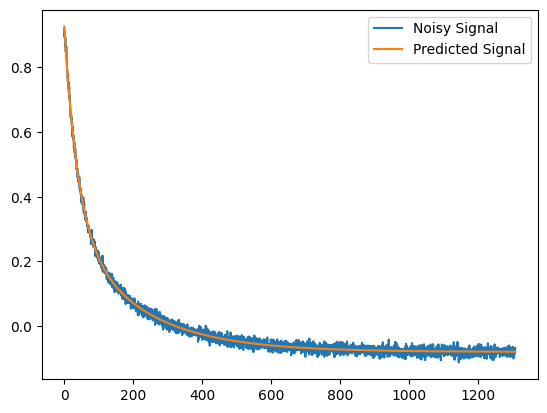

In [50]:
##########################
## Sensitivity Analysis ##
##########################

# We already have a time array and our fitted parameters
# We can use the fitted parameters to create a jacobian function
# that will allow us to calculate the sensitivity of the fitted parameters
# to the noisy signal.

def model_predictions(theta, t):
    params, c = theta[:-1], theta[-1]
    return multi_decay(params, t) + c

predicted_params = jnp.zeros(5)
predicted_params = predicted_params.at[1::2].set(tau)
predicted_params = predicted_params.at[0::2].set(linear_solve(noisy_signal, t, tau))

print(f"predicted_params: {predicted_params}")

# Compute the Jacobian with respect to theta for a single time point.
jac_fn = jacobian(lambda theta, t: model_predictions(theta, t))

# Vectorize the Jacobian over all time points.
J = vmap(lambda t: jac_fn(predicted_params, t))(t)

S = J @ jnp.linalg.inv(J.T @ J) @ J.T

print(f"sens shape: {S.shape}")

print(f"S trace: {jnp.trace(S)}")

# plot the signal 
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.plot(t, model_predictions(predicted_params, t), label="Predicted Signal")
plt.legend()
plt.show()
